# **Heart Sound Classification**

This project aims to classify heart beat sounds as normal or abnormal using machine learning. The dataset consists of audio recordings of heart sounds, our approach involves endoding the audio data into images, and using both classical computer vision (CCV) techniques as well as deep learning models and other approaches to perform the classification task.

**Table of Contents**

0. [Setup](#setup)

1. [Data Preprocessing](#data-preprocessing)
    * [Audio to Visual Encoding](#audio-to-visual-encoding)
    * [Label Processing](#label-processing)
    * [Data Splitting](#data-splitting)

2. [Exploratory Data Analysis](#exploratory-data-analysis)

    * [Visual Class Differentiation](#visual-class-differentiation)
    * [Average Spectrogram Difference](#average-spectrogram-difference)
    * [Frequency Energy Distribution](#frequency-energy-distribution)
    * [Audio Duration Distribution](#audio-duration-distribution)

3. [CCV Filter-Based Classification](#ccv-filter-based-classification)

    * [Integral Image Thresholding](#integral-image-thresholding)
    * [Sobel Edge Detection](#sobel-edge-detection)

4. [CCV Feature-Based Learning](#ccv-feature-based-learning)

5. [Deep Learning](#deep-learning)

6. [Pre-Trained Transfer Learning](#pre-trained-transfer-learning)

7. [Model Evaluation](#model-evaluation)

8. [Usage](#usage)

9. [Conclusion](#conclusion)

## **Setup**

Importing libraries and packages.

```bash
%cd ../
%uv venv .venv
%source activate .venv
!uv pip install -r requirements.txt
%cd src/
```

In [82]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import librosa
import librosa.display
from librosa.display import specshow, waveshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Audio, display
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
from scipy.ndimage import sobel

import warnings
warnings.filterwarnings('ignore')

Defining all constant paths.

In [2]:
ROOT_DIR = str(Path.cwd().parents[0])
DATA_DIR = os.path.join(ROOT_DIR, 'data')

DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)

print(f"root: {ROOT_DIR}")
print(f"data: {DATA_DIR}")
print(f"data processed: {DATA_PROCESSED_DIR}")

TRAINING_SETS = ["training-a", "training-b", "training-c", "training-d", "training-e", "training-f"]

print(f"training sets: {', '.join(i for i in TRAINING_SETS)}")

root: /Users/sepehrakbari/Projects/heart
data: /Users/sepehrakbari/Projects/heart/data
data processed: /Users/sepehrakbari/Projects/heart/data/processed
training sets: training-a, training-b, training-c, training-d, training-e, training-f


## **Data Preprocessing**

### Audio to Visual Encoding

To start our preprocessing, let's explore the data and see we are dealing with. To do so, I'll take the first audio file from each data collection session and work on that as an example throughout this section.

In [3]:
sample_paths = [
    os.path.join(DATA_DIR, 'training-a/a0001.wav'), 
    os.path.join(DATA_DIR, 'training-b/b0001.wav'),
    os.path.join(DATA_DIR, 'training-c/c0001.wav'),
    os.path.join(DATA_DIR, 'training-d/d0001.wav'),
    os.path.join(DATA_DIR, 'training-e/e00001.wav'),
    os.path.join(DATA_DIR, 'training-f/f0001.wav')
]
names = ['A', 'B', 'C', 'D', 'E', 'F']


sample_data = []

for i, path in enumerate(sample_paths):
    y, sr = librosa.load(path, sr=4000)
    sample_data.append({'y': y, 'sr': sr, 'name': names[i]})
    
    print(f"Sample {names[i]}")
    display(Audio(data=y, rate=sr))

Sample A


Sample B


Sample C


Sample D


Sample E


Sample F


The goal of our preprocessing section is to convert these raw audio files which a neural network cannot directly work with, into an image format that can be fed into a convolutional neural network (CNN). 

To start, lets shift our view to see these audio files as waveforms.

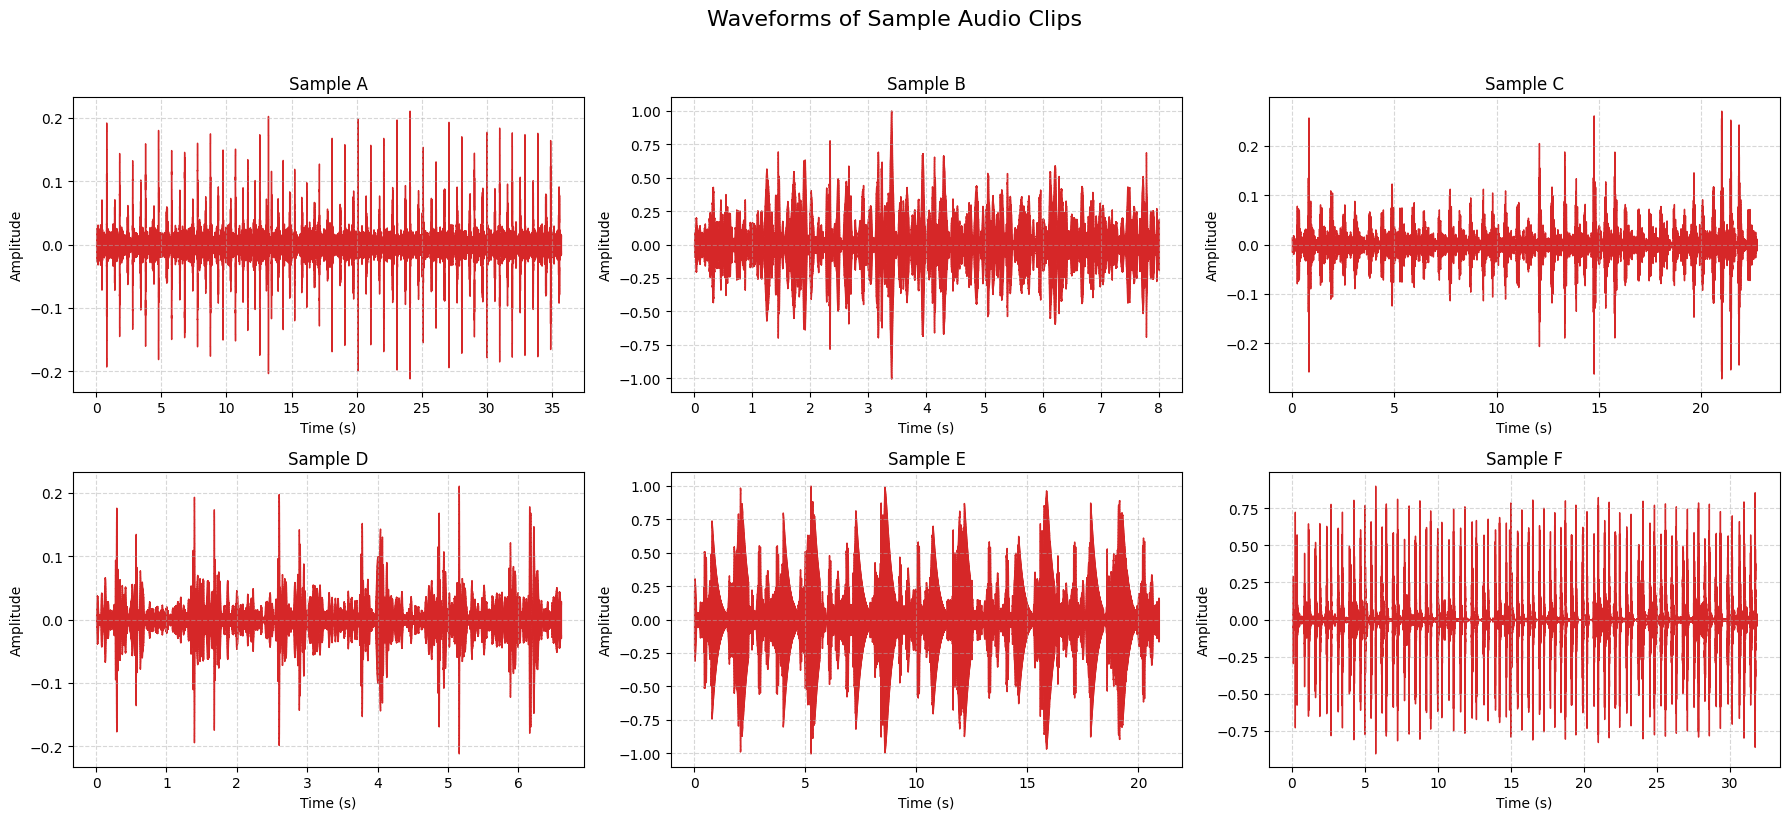

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
audio_data = [(x['y'], x['sr'], x['name']) for x in sample_data]
for i, (y, sr, label) in enumerate(audio_data):
    row = i // 3
    col = i % 3
    waveshow(y, sr=sr, ax=axs[row, col], axis='time', color='tab:red')
    axs[row, col].set_title(f"Sample {label}")
    axs[row, col].set_xlabel("Time (s)")
    axs[row, col].set_ylabel("Amplitude")
    axs[row, col].grid(True, linestyle='--', alpha=0.5)
    
plt.suptitle("Waveforms of Sample Audio Clips", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

We can take these waveforms, and apply a Fourier transform to convert them into frequency domain representations called spectrograms. These spectrograms can then be converted into Mel-spectrograms, which better align with human auditory perception. They will ultimately be represented as 2D images, capturing the frequency content over time, and can be used as input to our CNN model.

To create these Mel-spectrograms, we need to define some parameters. We will use the following parameters:

- **Sample Rate**: The number of samples of audio carried per second, this is typically set to around 20-40 thousand Hz, however, since heart sounds are relatively low frequency, we can use a lower sample rate of 4000 Hz.
- **Duration**: The length of each audio clip in seconds. We will standardize all audio clips to a fixed duration of 10 seconds.
- **Number of Mel Bands**: The number of Mel frequency bands to use in the Mel-spectrogram. This will determine the height of our spectrogram images. We will use 128 Mel bands, for a good balance between detail and computational efficiency.
- **FFT Window Size**: The size of the fast fourier transform window, which affects the time and frequency resolution of the spectrogram. If we set this too high, we may lose temporal resolution, and if we set it too low, we may lose frequency resolution. We will use a window size of 2048 samples.
- **Hop Length**: The number of samples between successive frames in the spectrogram. This determines how much overlap there is between adjacent windows. The size of this should be relative to th FFT window, so we will set it to a quarter of the FFT size, which is 512 samples.
- **fixed length**: Something we need to keep in mind is that all our spectograms need to have the same dimensions to get fed into the CNN. To ensure this, we will enforce a fixed number of time frames (width) in our spectrograms. Since our height (N_MELS) is 128, we will set the fixed length to 128 time frames as well to make square inputs.

In [5]:
SAMPLE_RATE = 4000 # samples per second (Hz)
DURATION = 20 # duration of each audio clip (seconds)
N_MELS = 128 # number of Mel bands (height of spectrogram)
N_FFT = 2048 # FFT window size
HOP_LENGTH = 512 # number of samples between frames
FIXED_LENGTH = 124 # fixed time frames (width of spectrogram)

We can include a function in our preprocessing pipeline to ensure that all audio signals are of the same length by either truncating or padding them as necessary.

In [6]:
def fix_length(y, fixed_length, hop_length, n_fft):
    """
    Adjust the length of the audio signal `y` to ensure it results in a spectrogram with `fixed_length` time frames.
    """
    goal = (fixed_length - 1) * hop_length + n_fft
    
    if len(y) > goal:
        # Truncate
        y_out = y[:goal]
    elif len(y) < goal:
        # Pad (with zeros)
        padding_needed = goal - len(y)
        y_out = np.pad(y, (0, padding_needed), mode='constant')
    else:
        y_out = y
    return y_out

Now that everything is set, we can load our audio file using our sample rate, adjust its length, and then convert it into a Mel-spectrogram image. I'll first demonstrate this process on our sample audio files.

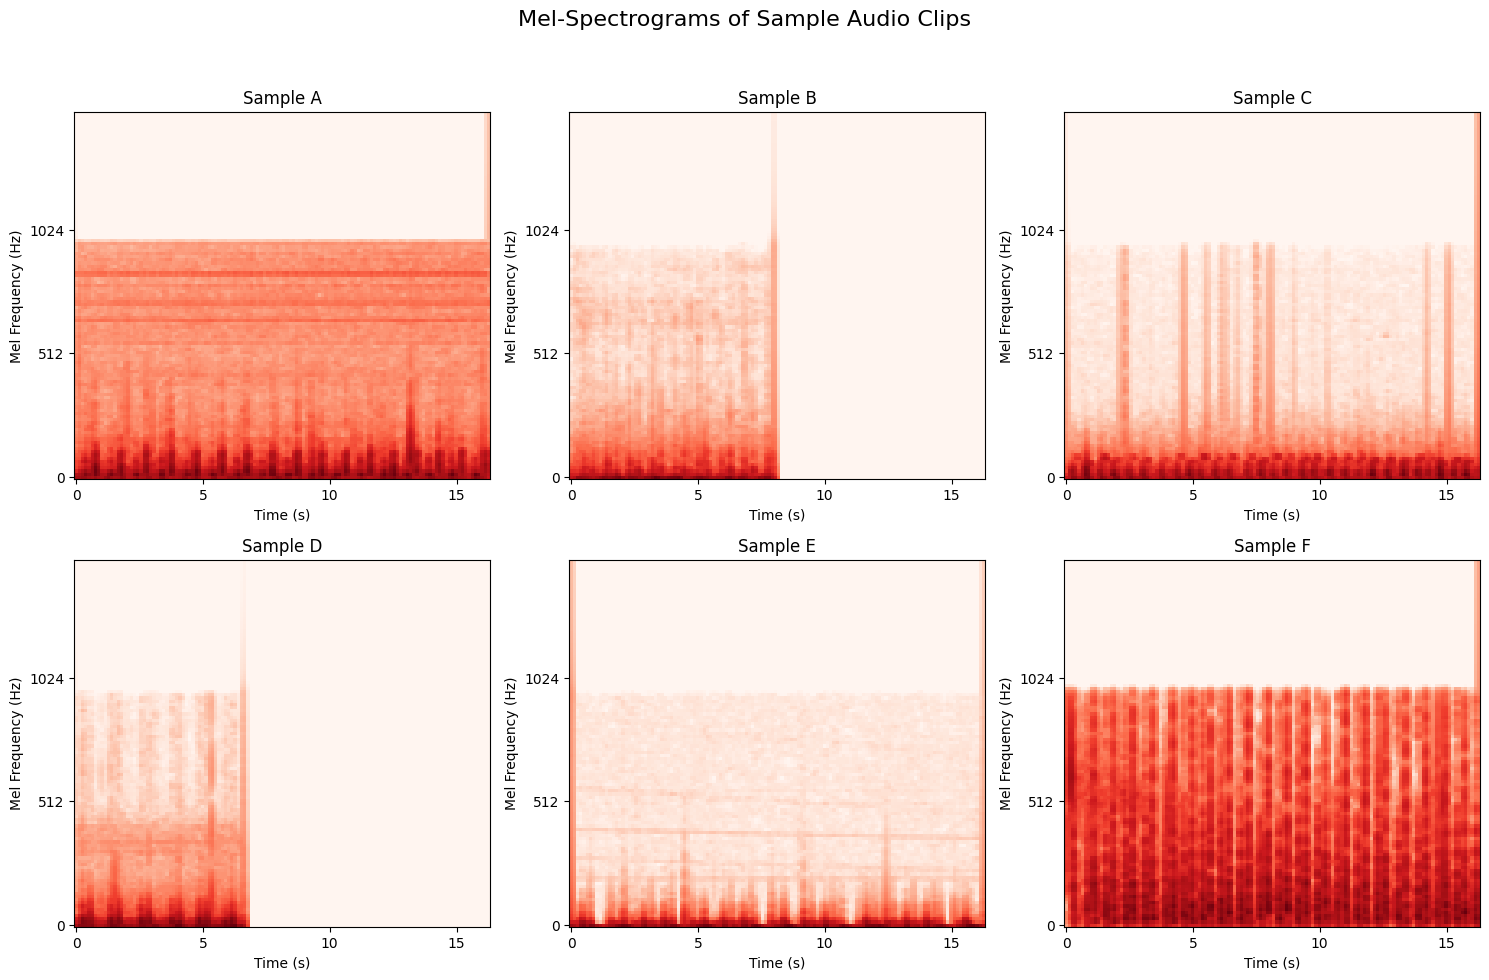

In [7]:
plt.figure(figsize=(15, 15))

for i, data in enumerate(sample_data):
    ax = plt.subplot(3, 3, i + 1)
    
    y = data['y']
    sr = data['sr']
    name = data['name']
    
    y_fixed = fix_length(y, FIXED_LENGTH, HOP_LENGTH, N_FFT)
    
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y_fixed,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    librosa.display.specshow(
        mel_spectrogram_db,
        sr=sr,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        cmap='Reds',
        ax=ax
    )
    
    plt.title(f'Sample {name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency (Hz)')

for j in range(len(sample_data) + 1, 10):
    plt.subplot(3, 3, j).set_visible(False)

plt.suptitle(f'Mel-Spectrograms of Sample Audio Clips', 
             fontsize=16, y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


This shows the Mel-spectrogram of our sample audio file. The x-axis represents time, the y-axis represents Mel frequency bands, and the color intensity indicates the amplitude of each frequency band at each time frame. Of course, since some files are shorter or longer than others, the spectrograms will either be padded with zeros or truncated to ensure they all have the same dimensions.

### Label Processing

Now to save the files for the training process, we define their resolution and load them all in.

In [8]:
DPI = 100
FIGSIZE = (N_MELS / DPI, FIXED_LENGTH / DPI)

def make_melspec(audio_path, output_path):
    """
    Loads and generate Mel-spectrograms.
    """
    try:
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        
        y_fixed = fix_length(y, FIXED_LENGTH, HOP_LENGTH, N_FFT)

        mel_spectrogram = librosa.feature.melspectrogram(
            y=y_fixed, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        plt.figure(figsize=FIGSIZE, dpi=DPI)
        
        librosa.display.specshow(mel_spectrogram_db, cmap='plasma')
        
        plt.axis('off')
        plt.tight_layout(pad=0)
        
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        return True

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return False

We also have to load our labels (normal/abnormal) from the annotation files. I'll combine all of them into a single dataframe for easier access later on.

Since the dataset comes with its own validation set and different training sets (recorded at different times), I will read all the labels and note where each sample comes from for future reference. Also note, some of these recording are marked as lower quality, and for commercial use they should be excluded, however for academic purposes we can include them all to have more data to train on (this is the recommended approach by the dataset authors).

In [9]:
def read_labels():
    """
    Reads all annotation files and combines them into a single DataFrame.
    """
    all_labels = []
    
    training_annotation_files = glob.glob(os.path.join(DATA_DIR, 'training-*', 'REFERENCE.csv'))
    val_annotation_file = os.path.join(DATA_DIR, 'validation', 'REFERENCE.csv')
    
    for file_path in training_annotation_files:
        try:
            df = pd.read_csv(file_path, header=None, names=['Name', 'Label'])
            df['Set'] = os.path.basename(os.path.dirname(file_path))
            all_labels.append(df)
        except Exception as e:
            print(f"Could not read {file_path}. Error: {e}")
    
    try:
        df_val = pd.read_csv(val_annotation_file, header=None, names=['Name', 'Label'])
        df_val['Set'] = 'validation'
        all_labels.append(df_val)
    except Exception as e:
        print(f"Warning: Could not read validation annotation file. Error: {e}")

    if all_labels:
        master_df = pd.concat(all_labels, ignore_index=True)
        master_df['Name'] = master_df['Name'].apply(lambda x: x + '.png')
        return master_df
    else:
        print("ERROR: No labels collected from any file.")
        return pd.DataFrame()
    
labels_df = read_labels()
display(labels_df.sample(5, random_state=325))

,Name,Label,Set
1713,e01224.png,-1,training-e
1491,e01002.png,-1,training-e
2311,e01822.png,-1,training-e
2189,e01700.png,-1,training-e
1782,e01293.png,-1,training-e


The labels are stored in the same format of the annotations. The label is whether the heart beat is normal (-1) or abnormal (1).

In [10]:
def process_data():
    """
    Process all audio files and labels.
    """
    data_subfolders = glob.glob(os.path.join(DATA_DIR, 'training-*'))
    validation_folder = os.path.join(DATA_DIR, 'validation')
    
    if os.path.isdir(validation_folder):
        data_subfolders.append(validation_folder)

    if not data_subfolders:
        print("No subdirectories found.")
        return None, None

    processed = 0
    
    for folder_idx, subfolder_path in enumerate(data_subfolders):
        subfolder_name = os.path.basename(subfolder_path)
        output_subfolder = os.path.join(DATA_PROCESSED_DIR, subfolder_name)
        os.makedirs(output_subfolder, exist_ok=True)
        
        wav_files = glob.glob(os.path.join(subfolder_path, '*.wav'))
        
        print(f"\nProcessing Folder #{folder_idx + 1}: {subfolder_name} ({len(wav_files)} files)")

        for wav_count, wav_path in enumerate(wav_files):
            if (wav_count + 1) % 100 == 0:
                print(f"Processed {wav_count + 1} of {len(wav_files)}")
            
            file_name = os.path.basename(wav_path)
            output_file_name = file_name.replace('.wav', '.png')
            output_path = os.path.join(output_subfolder, output_file_name)
            
            if make_melspec(wav_path, output_path): 
                processed += 1

    global_labels_df = read_labels()
    
    labels_output_path = os.path.join(DATA_PROCESSED_DIR, 'labels_raw.csv')
    global_labels_df.to_csv(labels_output_path, index=False)
    
    print(f"\nTotal audio files processed: {processed}")
    print(f"Total labels collected: {len(global_labels_df)}")
    print(f"Labels saved to: {labels_output_path}")

    return global_labels_df, DATA_PROCESSED_DIR

In [11]:
# labels, processed_dir = process_data()

# if labels is not None and not labels.empty:
#     display(labels.head())
#     display(labels['Label'].value_counts())

To make the labels easier to use later on, I will add an additional column to map the file names to their corresponding Mel-spectrogram image files, and also make the labels 0/1 instead of -1/1, this is more standard for binary classification but ultimately does not matter.

In [12]:
LABELS_PATH = os.path.join(DATA_PROCESSED_DIR, 'labels_raw.csv')
labels_df = pd.read_csv(LABELS_PATH)

def get_full_path(row):
    subfolder = row['Set']
    filename = row['Name']
    return os.path.join(DATA_PROCESSED_DIR, subfolder, filename)

labels_df['Image'] = labels_df.apply(get_full_path, axis=1)
labels_df['Label'] = labels_df['Label'].map({-1: 0, 1: 1})

FINAL_DATA_PATH = os.path.join(DATA_PROCESSED_DIR, 'labels.csv')
labels_df.to_csv(FINAL_DATA_PATH, index=False)

print(f"Final dataset shape: {labels_df.shape}")
labels_df.sample(5, random_state=42)

Final dataset shape: (3541, 4)


,Name,Label,Set,Image
712,e00223.png,0,training-e,/Users/sepehrakbari/Projects/heart/data/proces...
279,b0280.png,1,training-b,/Users/sepehrakbari/Projects/heart/data/proces...
1456,e00967.png,1,training-e,/Users/sepehrakbari/Projects/heart/data/proces...
3505,e00266.png,1,validation,/Users/sepehrakbari/Projects/heart/data/proces...
2194,e01705.png,0,training-e,/Users/sepehrakbari/Projects/heart/data/proces...


### Data Splitting

All data is now processed, meaning the Mel-spectrogram images are saved, and the labels dataframe is ready for use in training our model. However, there are two issues to address before we can proceed:

1.  **Class Imbalance**: The dataset is imbalanced, with significantly more normal recordings than abnormal ones. This could lead to a biased model that performs poorly on the minority class. For now, I won't over-sample or under-sample, but I will keep this in mind in future steps.

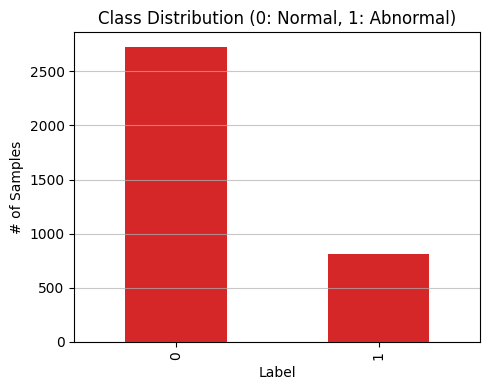

In [13]:
LABELS_PATH = os.path.join(DATA_PROCESSED_DIR, 'labels.csv')
labels_df = pd.read_csv(LABELS_PATH)

plt.figure(figsize=(5, 4))
labels_df['Label'].value_counts().plot(kind='bar', color='tab:red')
plt.title('Class Distribution (0: Normal, 1: Abnormal)')
plt.xlabel('Label')
plt.ylabel('# of Samples')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

2. **Val/Train Overlap**: The validation set contains some samples that are also present in the training set, which could lead to data leakage and overly optimistic performance estimates. I will need to ensure that the validation set is truly independent of the training data. This is why I noted where each sample came from in the labels dataframe, so now I will split the data using the 'Set' column, and remove any overlapping samples from the training set.

*Note: I'll take the testing set from the training data later on.*

In [14]:
validation_df = labels_df[labels_df['Set'] == 'validation'].copy()
training_and_test_df_raw = labels_df[labels_df['Set'].str.startswith('training')].copy()

validation_filenames = set(validation_df['Name'])

training_and_test_df = training_and_test_df_raw[
    ~training_and_test_df_raw['Name'].isin(validation_filenames)
].copy()

removed_count = len(training_and_test_df_raw) - len(training_and_test_df)

print(f"Total samples in validation set: {len(validation_df)}")
print(f"Total duplicate samples removed from training sets: {removed_count}")

print(f"\nFinal training/test set shape: {training_and_test_df.shape}")
print(f"Final validation set shape: {validation_df.shape}")

Total samples in validation set: 301
Total duplicate samples removed from training sets: 301

Final training/test set shape: (2939, 4)
Final validation set shape: (301, 4)


Splitting the data by feature and target variables, and then I'll split the data into training and test sets.

Since the total images is 2939 + 301 = 3240, 20% of that is 648, so I'll take 648 samples from the training set as the test set, which is about 22% of the train_test set.

In [15]:
X = training_and_test_df['Image']
y = training_and_test_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.22, 
    random_state=325, 
    stratify=y
)

train_df = pd.DataFrame({'Image': X_train, 'Label': y_train}).reset_index(drop=True)
test_df = pd.DataFrame({'Image': X_test, 'Label': y_test}).reset_index(drop=True)
val_df = validation_df[['Image', 'Label']].reset_index(drop=True)

split_eval = pd.DataFrame({
    'Set': ['Train', 'Test', 'Val'],
    'Total Samples': [len(X_train), len(X_test), len(validation_df)],
    'Abnormal (Label=1)': [y_train.sum(), y_test.sum(), validation_df['Label'].sum()],
    'Normal (Label=0)': [len(X_train) - y_train.sum(), len(X_test) - y_test.sum(), len(validation_df) - validation_df['Label'].sum()]
})

split_eval['Abnormal %'] = (split_eval['Abnormal (Label=1)'] / split_eval['Total Samples'] * 100).round(2)
display(split_eval)

,Set,Total Samples,Abnormal (Label=1),Normal (Label=0),Abnormal %
0,Train,2292,401,1891,17.50
1,Test,647,113,534,17.47
2,Val,301,151,150,50.17


The table above summarizes the distribution of normal and abnormal samples in the training, validation, and test sets. It includes some very good news as well! The training and testing sets are very well split, with about 83% normal and 17% abnormal samples in both sets. This consistency will help the model generalize better. The validation set, however, has about 50% normal and 50% abnormal samples, which is great because we primarily will use validation accuracy to tune hyperparameters and select models, so having a balanced validation set will give us a better estimate of model performance across both classes, and it will help ensure that the model does not overfit to the majority class during training.

## **Exploratory Data Analysis**

### Visual Class Differentiation

Before training any models, it's important to understand the data we're working with. One way to do this is by visually inspecting the Mel-spectrograms of normal and abnormal heart sounds to see if there are any discernible patterns or differences between the two classes.

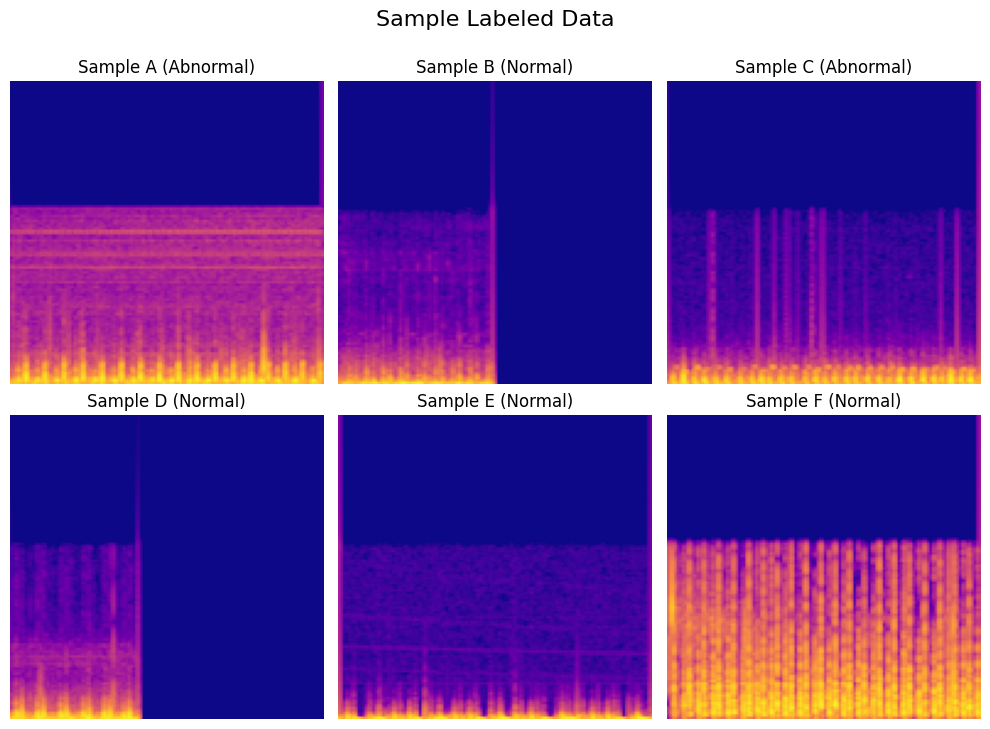

In [16]:
all_labels_df = pd.read_csv(f'{DATA_PROCESSED_DIR}/labels.csv')

sample_indices = ['a0001.png', 'b0001.png', 'c0001.png', 'd0001.png', 'e00001.png', 'f0001.png']
sets = ['A', 'B', 'C', 'D', 'E', 'F']
sample_images = all_labels_df[all_labels_df['Name'].isin(sample_indices)].drop_duplicates(subset='Name').reset_index(drop=True)
sample_images = sample_images.set_index('Name').loc[sample_indices].reset_index()

max_plots = min(len(sample_images), 9)

plt.figure(figsize=(10, 12))
for i in range(max_plots):
    row = sample_images.iloc[i]
    img_path = row['Image']
    label = row['Label']
    
    img = plt.imread(img_path)
    
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Sample {sets[i]} ({'Abnormal' if label == 1 else 'Normal'})")
    
for j in range(max_plots + 1, 10):
    plt.subplot(3, 3, j).set_visible(False)
    
plt.suptitle("Sample Labeled Data", fontsize=16, y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

From at least this small sample, containing 2 abnormal and 4 normal samples, we can not really see any clear visual differences between the normal and abnormal heart sounds.

### Average Spectrogram Difference

To get a better sense of the overall differences, and spefically using the commonality of the spectograms within each class, we can compute the average Mel-spectrogram for normal and abnormal heart sounds separately, and then visualize the difference between these two average spectrograms.

We'll start by converting each image into a numpy array and computing the mean spectrogram for each class. First, I'll define a function to load and vectorize the spectrogram images with values between 0-255.

In [17]:
def vectorize_spec(path):
    """Loads a spectrogram image and converts it to a NumPy array."""
    try:
        img = Image.open(path).convert('L') # L mode for grayscale
        return np.array(img, dtype=np.float32)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None
    
sample_path = sample_images.iloc[0]['Image']
spec_array = vectorize_spec(sample_path)
print(f"Vectorized spectrogram for Sample A: \n\n{spec_array}")

Vectorized spectrogram for Sample A: 

[[ 24.  24.  24. ...  24.  45.  54.]
 [ 24.  24.  24. ...  24.  45.  54.]
 [ 24.  24.  24. ...  24.  45.  54.]
 ...
 [156. 171. 187. ... 187. 196. 184.]
 [184. 189. 197. ... 192. 192. 179.]
 [193. 196. 200. ... 199. 192. 173.]]


Now We can separate our data into normal and abnormal classes, load their spectrograms, and compute the mean spectrogram for each class.

In [18]:
normal_paths = all_labels_df[all_labels_df['Label'] == 0]['Image'].tolist()
abnormal_paths = all_labels_df[all_labels_df['Label'] == 1]['Image'].tolist()

normal_spectrograms = [vectorize_spec(p) for p in normal_paths if vectorize_spec(p) is not None]
abnormal_spectrograms = [vectorize_spec(p) for p in abnormal_paths if vectorize_spec(p) is not None]

mean_normal_spec = np.mean(np.stack(normal_spectrograms), axis=0)
mean_abnormal_spec = np.mean(np.stack(abnormal_spectrograms), axis=0)

Before we plot, we can also compute the difference between the mean normal and mean abnormal spectrograms to highlight the areas where they differ the most. This may allow us to identify specific frequency bands or time intervals that are more indicative of abnormal heart sounds visually.

We can then visualize the mean spectrograms for normal and abnormal heart sounds, as well as their difference.

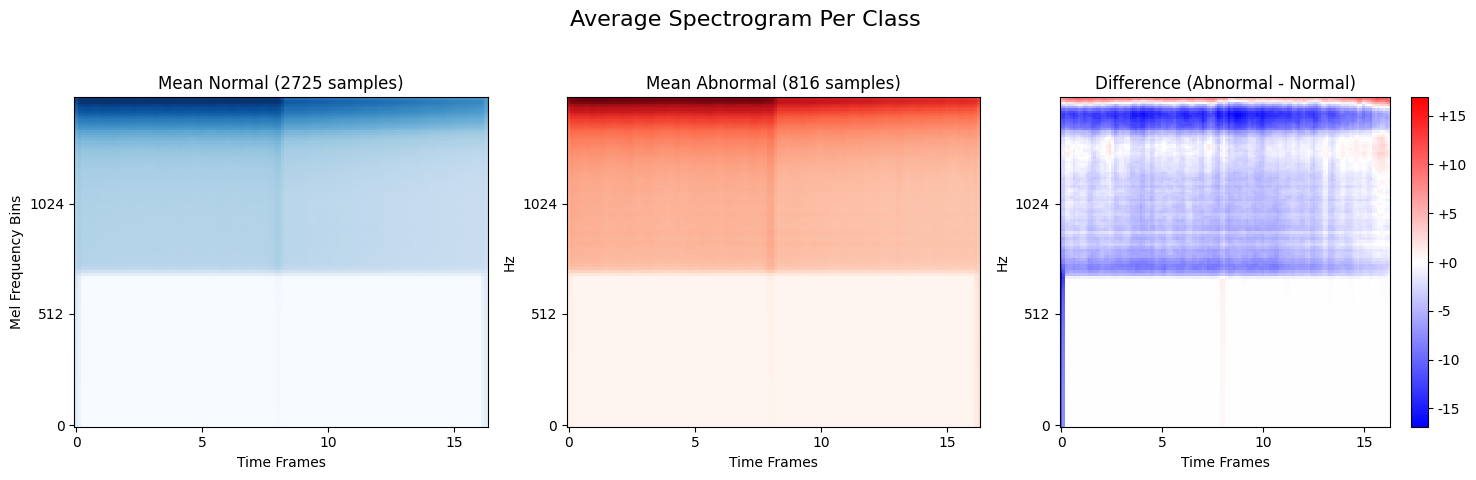

In [19]:
difference_map = mean_abnormal_spec - mean_normal_spec

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Average Spectrogram Per Class', fontsize=16)

specshow(mean_normal_spec, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=axes[0], cmap='Blues')
axes[0].set_title(f'Mean Normal ({len(normal_spectrograms)} samples)')
axes[0].set_xlabel('Time Frames')
axes[0].set_ylabel('Mel Frequency Bins')

specshow(mean_abnormal_spec, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=axes[1], cmap='Reds')
axes[1].set_title(f'Mean Abnormal ({len(abnormal_spectrograms)} samples)')
axes[1].set_xlabel('Time Frames')

max_abs = np.max(np.abs(difference_map))
im = specshow(difference_map, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=axes[2], 
                              cmap='bwr', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Difference (Abnormal - Normal)')
axes[2].set_xlabel('Time Frames')
fig.colorbar(im, ax=axes[2], format='%+2.f',)

plt.grid(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observe that in the difference plot, areas where the color is closer to white indicate little to no difference between the two classes. Blue areas indicate that the normal class has higher average intensity in those regions, and red areas indicate that the abnormal class has higher average intensity.

The figures validate that the true signal is time-based and frequency-localized. They can also reveal some characteristics about the two classes:

- The abnormal heart sound is characterized by consistent, higher-frequency spectral content that lasts the entire duration of the recording. This is the signature of a persistent heart murmur or continuous breathing/friction that is high-frequency noise. 

- The normal class has slightly more energy than the Abnormal class in the very low frequencies , which is likely just a statistical artifact or due to the Abnormal data being normalized differently. 

- It's also important to note that this energy is present across the entire 16.7 seconds.

### Frequency Energy Distribution

Beyond visual differences, we can also analyze the distribution of frequency energy across the two classes. This is an important step which can give us some initial clues on how deep our neural models should be. If both lines track closely but the abnormal line is just slightly higher overall, we need a deep CNN to find subtle differences. If there's a big spike in a specific frequency range, we can justify a simple, shallow CNN focused on that area.

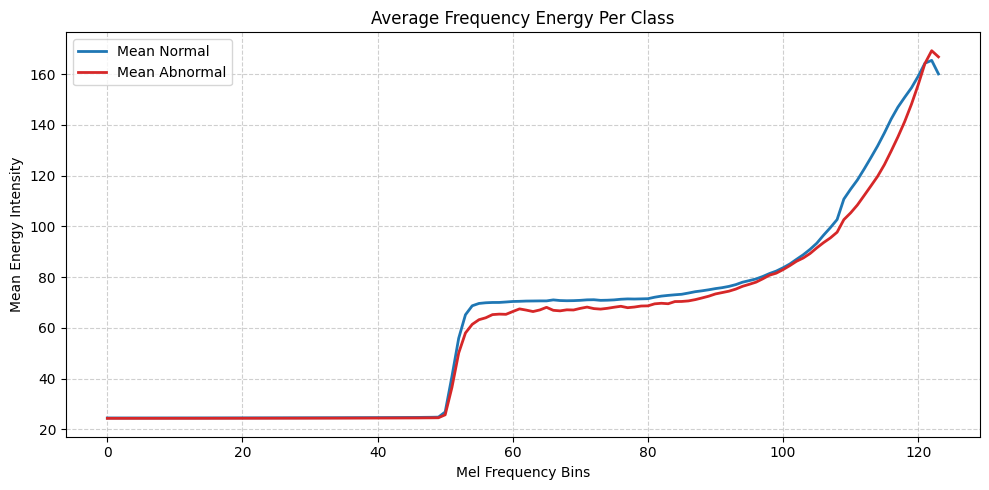

In [20]:
normal_energy_profile = np.mean(mean_normal_spec, axis=1)
abnormal_energy_profile = np.mean(mean_abnormal_spec, axis=1)

plt.figure(figsize=(10, 5))

plt.plot(normal_energy_profile, label='Mean Normal', color='tab:blue', linewidth=2)
plt.plot(abnormal_energy_profile, label='Mean Abnormal', color='tab:red', linewidth=2)
plt.title('Average Frequency Energy Per Class')
plt.xlabel('Mel Frequency Bins')
plt.ylabel('Mean Energy Intensity')
plt.grid(True, alpha=0.6, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

This plot reveals that frequency range usage is nearly identical between normal and abnormal classes. Looking closely:

- In low frequencies: Energy is low and identical. This is where the main heart sounds usually live, but on average, there's no overall energy difference here.

- In mid frequencies: Energy rises sharply and tracks almost perfectly between the two classes, until the very highest bins (~100). We can also see some minor fluctuations in the abnormal line here, likely due to the higher frequency content seen in the average spectrogram.

- Spikes: The abnormal line rises slightly faster and higher than the normal line at the highest frequency bins. Have in mind that the sharp decrease at the end is due to the data preprocessing step and does not represent a true drop in energy.

Overall the abnormality is not a broad-band noise issue. If the abnormal class had a lot of background friction or high-frequency patient movement noise, the red line would be significantly higher across the entire spectrum. The subtle difference at the high end suggests that the abnormalities are specific, short-burst events that don't add much to the average energy profile, except possibly in the highest, least meaningful bins (which are often just noise).

### Audio Duration Distribution

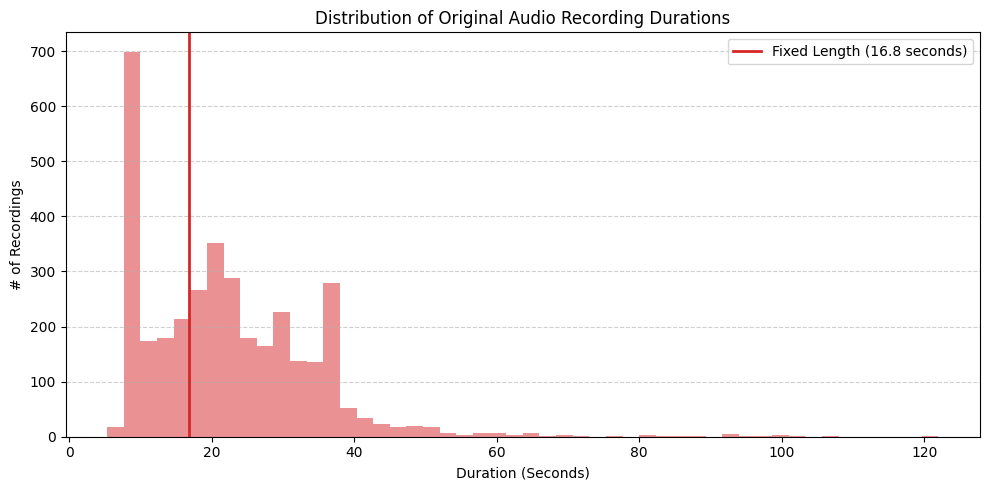

In [21]:
original_durations = []
for col, row in all_labels_df.iterrows():
    wav_path = os.path.join(DATA_DIR, row['Set'], row['Name'].replace('.png', '.wav'))
    
    if os.path.exists(wav_path):
        try:
            duration = librosa.get_duration(path=wav_path, sr=SAMPLE_RATE)
            original_durations.append(duration)
        except Exception:
            continue

plt.figure(figsize=(10, 5))

fixed_duration = (128 - 1) * 512 + 2048 # this formula comes from the spectrogram parameters defined earlier
fixed_duration_seconds = fixed_duration / SAMPLE_RATE

plt.hist(original_durations, bins=50, color='tab:red', alpha=0.5)
plt.axvline(fixed_duration_seconds, 
            color='tab:red', linewidth=2, 
            label=f'Fixed Length ({fixed_duration_seconds:.1f} seconds)')
plt.title('Distribution of Original Audio Recording Durations')
plt.xlabel('Duration (Seconds)')
plt.ylabel('# of Recordings')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

This plot shows how varied the original audio recording lengths are in our dataset. This definitely justifies our preprocessing step of enforcing a fixed length for all audio samples, and adding padding or truncating as necessary. Our choice of the 16.8 seconds fixed length seems appropriate, as it provides a good balance between covering many recordings fully, while not being excessively long and adding too much padding for shorter samples.

Have in mind that this balance is very important, cause we don't want our neural network to learn from the padding segments, or the noise introduced by truncating the audio.

## **CCV Filter-Based Classification**



### Integral Image Thresholding

Now that we have a good understanding of our data, and have justified our preprocessing choices, we can move on to building our first classification model!

Since we have already how the intensity distribution varies across frequency bands for the two classes, we can start with classifying based on these intensities directly, using a simple thresholding approach. In classical computer vision (CCV), there exists a method called Integral Images, also known as Summed Area Tables, which allows for us to compute the average energy in the most differentiated area of the spectrogram.

Based on our EDA, we can see that the most differentiated area is in the higher frequency bands, so we can focus our classification on just the top half of the spectrogram. I'll implement this to take in an image and compute the average intensity in the top half of the spectrogram, and use that as a feature for classification.

In [22]:
def mean_img(image_path):
    """
    Extracts the overall average energy from the spectrogram.
    """
    try:
        img = Image.open(image_path).convert('L')
        spec_array = np.array(img, dtype=np.float32)
    except Exception:
        return 0.0 

    return np.mean(spec_array) # overall average energy

def intgrl_img(image_path, n_mels=128):
    """
    Extracts the average energy from the high-frequency half of the spectrogram.
    """
    try:
        img = Image.open(image_path).convert('L')
        spec_array = np.array(img, dtype=np.float32)
    except Exception:
        return 0.0 

    top_half = spec_array[n_mels // 2:, :]
    return np.mean(top_half) # average energy of top half frequencies

sample_image_path = all_labels_df.iloc[0]['Image']
high_freq_energy = intgrl_img(sample_image_path)
overall_energy = mean_img(sample_image_path)

print(f"mean of overall energy (Sample A): {overall_energy:.2f}")
print(f"mean of high-frequency energy (Sample A): {high_freq_energy:.2f}")

mean of overall energy (Sample A): 36.79
mean of high-frequency energy (Sample A): 48.54


Next, I'll define a threshold based on the average high-frequency energy computed from the training set. In this approach, let any sample with a 5% higher high-frequency energy than this threshold be classified as abnormal, otherwise normal.

In [145]:
normal_train_df = train_df[train_df['Label'] == 0]
normal_features_ccv1_b1 = normal_train_df['Image'].apply(intgrl_img).values

threshold_mean_ccv1_b1 = np.mean(normal_features_ccv1_b1)
threshold_ccv1_b1 = threshold_mean_ccv1_b1 * 1.05

print(f"Mean high-freq energy for normal training samples: {threshold_mean_ccv1_b1:.2f}")
print(f"Classification threshold (mu + 5%): {threshold_ccv1_b1:.2f}")

Mean high-freq energy for normal training samples: 94.39
Classification threshold (mu + 5%): 99.11


Let's test this simple classifier on our test set and see how well it performs.


Accuracy: 51.3%

              precision    recall  f1-score   support

  Normal (0)       0.80      0.55      0.65       534
Abnormal (1)       0.14      0.34      0.19       113

    accuracy                           0.51       647
   macro avg       0.47      0.44      0.42       647
weighted avg       0.68      0.51      0.57       647



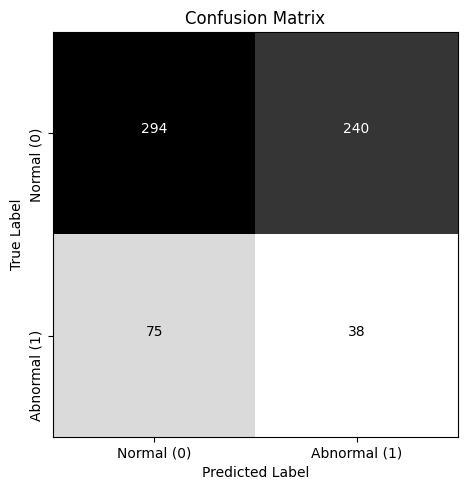

In [146]:
test_features_ccv1_b1 = test_df['Image'].apply(intgrl_img).values
test_true_ccv1_b1 = test_df['Label'].values

test_pred_ccv1_b1 = (test_features_ccv1_b1 > threshold_ccv1_b1).astype(int)

print(f"\nAccuracy: {accuracy_score(test_true_ccv1_b1, test_pred_ccv1_b1) * 100:.1f}%\n")
print(classification_report(test_true_ccv1_b1, test_pred_ccv1_b1, target_names=['Normal (0)', 'Abnormal (1)']))

cm = confusion_matrix(test_true_ccv1_b1, test_pred_ccv1_b1)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap="binary")
plt.title('Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal (0)', 'Abnormal (1)'])
plt.yticks(tick_marks, ['Normal (0)', 'Abnormal (1)'], rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

The results reveal that this model is just slightly better than random guessing! Which is not very surprising given the very subtle differences we observed in the EDA. Moreover, observe that although our accuracy is around 51%, the precision for the abnormal class is at about 14%, which stems from the class imbalance in the test set. This means that when the model predicts a sample as abnormal, it's only correct about 14% of the time, which is quite low. This would also mean that we could simply increase the threshold to classify almost all samples as normal, and achieve a high accuracy but of course be left with a useless model.

To demonstrate this further, this is the same classification done on the validation set, which is balanced between normal and abnormal samples.


Accuracy: 46.5%

              precision    recall  f1-score   support

  Normal (0)       0.47      0.63      0.54       150
Abnormal (1)       0.45      0.30      0.36       151

    accuracy                           0.47       301
   macro avg       0.46      0.47      0.45       301
weighted avg       0.46      0.47      0.45       301



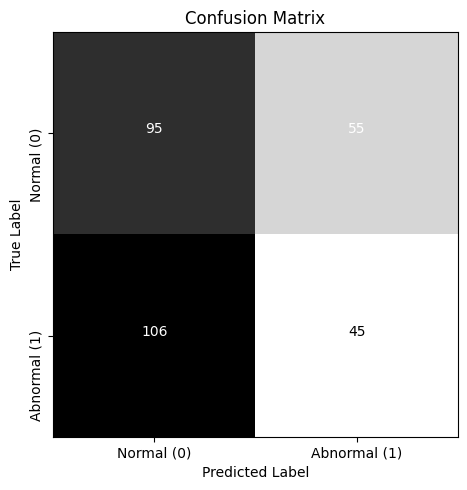

In [147]:
val_features_ccv1_b1 = val_df['Image'].apply(intgrl_img).values
val_true_ccv1_b1 = val_df['Label'].values

val_pred_ccv1_b1 = (val_features_ccv1_b1 > threshold_ccv1_b1).astype(int)

print(f"\nAccuracy: {accuracy_score(val_true_ccv1_b1, val_pred_ccv1_b1)* 100:.1f}%\n")
print(classification_report(val_true_ccv1_b1, val_pred_ccv1_b1, target_names=['Normal (0)', 'Abnormal (1)']))

cm = confusion_matrix(val_true_ccv1_b1, val_pred_ccv1_b1)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap="binary")
plt.title('Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal (0)', 'Abnormal (1)'])
plt.yticks(tick_marks, ['Normal (0)', 'Abnormal (1)'], rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

Here, the accuracy is around 46.5%, so even worse than random guessing, but the precision for both classes is about the same at around 50%. Of course, we see a better recall for the normal set, since the model is biased towards predicting normal due to the threshold being based on the training set distribution.

### Sobel Edge Detection

Our second filter-based CCV approach will explore whether how often the noise starts and stops in the spectrogram can be used as a differentiating factor between normal and abnormal heart sounds. The idea here is that abnormal heart sounds may have more abrupt changes in frequency content due to murmurs or other irregularities. These could be captured as edges in the spectrogram image.

I will implement (using SciPy) a standard edge detection filter, the Sobel filter, to identify these abrupt changes in the spectrograms. The Sobel filter computes the gradient of the image intensity, highlighting areas with high spatial frequency which correspond to edges.

Note that I will implement this on the Integral Image feature we defined earlier, meaning I will first compute the high-frequency energy using the integral image method, and then apply the Sobel filter to that result to detect edges in the high-frequency energy distribution. This way, we can see if the rate of change in high-frequency energy is a useful feature for classification.

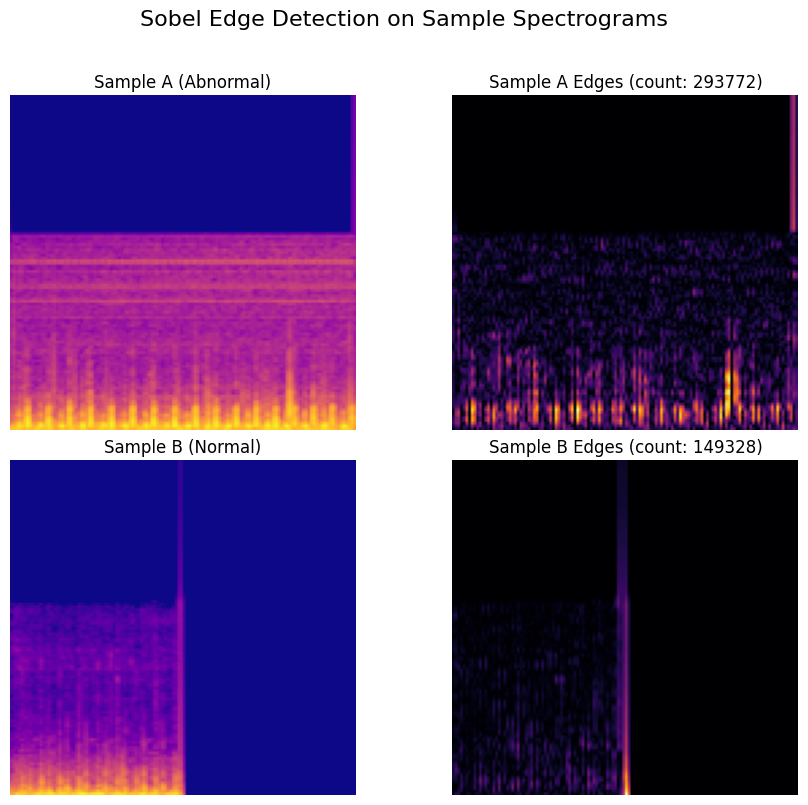

In [144]:
def edges_img(image_path):
    """
    Takes an image path, applies Sobel edge detection, and returns image with edges highlighted.
    """
    try:
        img = Image.open(image_path).convert('L')
        spec_array = np.array(img, dtype=np.float32)
    except Exception:
        return None 

    edge_detection = np.abs(sobel(spec_array, axis=1))
    
    return edge_detection

def count_edges(spec_array, n_mels=128):
    """Extracts the sum of vertical edges in the high-frequency half."""
    if spec_array is None: 
        return 0.0
    
    edge_detection = np.abs(sobel(spec_array, axis=1))
    
    high_freq_edges = edge_detection[n_mels // 2:, :]
    
    return np.sum(high_freq_edges)

img1 = sample_images.iloc[0]['Image']
img2 = sample_images.iloc[1]['Image']

edge_img1 = edges_img(img1)
edge_img2 = edges_img(img2)

edge_img1_count = count_edges(vectorize_spec(img1))
edge_img2_count = count_edges(vectorize_spec(img2))

fig, axes = plt.subplots(2, 2, figsize=(9,9))

axes[0, 0].imshow(plt.imread(img1), cmap='gray')
axes[0, 0].set_title(f'Sample A {"(Abnormal)" if sample_images.iloc[0]["Label"] == 1 else "(Normal)"}')
axes[0, 0].axis('off')

axes[0, 1].imshow(edge_img1, cmap='inferno')
axes[0, 1].set_title(f'Sample A Edges (count: {edge_img1_count:.0f})')
axes[0, 1].axis('off')

axes[1, 0].imshow(plt.imread(img2), cmap='gray')
axes[1, 0].set_title(f'Sample B {"(Abnormal)" if sample_images.iloc[1]["Label"] == 1 else "(Normal)"}')
axes[1, 0].axis('off')

axes[1, 1].imshow(edge_img2, cmap='inferno')
axes[1, 1].set_title(f'Sample B Edges (count: {edge_img2_count:.0f})')
axes[1, 1].axis('off')

plt.suptitle('Sobel Edge Detection on Sample Spectrograms', fontsize=16, y=0.92)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [ ]:
# normal_features_ccv1_b1 = normal_train_df['Image'].apply(intgrl_img).values

normal_features_ccv1_b2 = []

AxisError: axis 1 is out of bounds for array of dimension 0

## **CCV Feature-Based Learning**

## **Deep Learning**

## **Pre-Trained Transfer Learning**